## Data Sources and Import Statements

Data have been downloaded from the Earth System Grid Federation at https://esgf-node.ipsl.upmc.fr/projects/esgf-ipsl/.

Each file has been concatenated to contain ssp119 and ssp126 scenarios and r1-5 ensemble members from 2015 to 2100. Each has also been regridded to 2.5° resolution.

In [61]:
# IMPORT STATEMENTS

#General useful libraries
import math
import os
import re
#Loading in data (netcdf files)
import h5py
#Handling data
import numpy as np
import netCDF4 as nc
import xarray as xr
#Plotting figures
import matplotlib.pyplot as plt #Main plotting package
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker

#Machine Learning package
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() 
print(tf.__version__)

#Interpreting neural networks 
import shap

2.18.0


## Loading Data/Checking Shape & Dimension

In [62]:
files = [
    "CNRM_ESM2-1_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "MIROC6_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "MPI-ESM1-2-LR_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "MRI-ESM2-0_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "UKESM1-0-LL_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
] 

ds = nc.Dataset(files[0])
print(list(ds.variables.keys()))
ds.close()

['lat', 'lon', 'time', 'data_ssp119', 'data_ssp126']


In [63]:
ds = nc.Dataset(files[0])

print("data_ssp119 shape:", ds["data_ssp119"].shape)
print("data_ssp126 shape:", ds["data_ssp126"].shape)

print("data_ssp119 dims:", ds["data_ssp119"].dimensions)
print("data_ssp126 dims:", ds["data_ssp126"].dimensions)

ds.close()

data_ssp119 shape: (5, 7, 1032, 144, 73)
data_ssp126 shape: (5, 7, 1032, 144, 73)
data_ssp119 dims: ('ensemble', 'variable', 'time', 'lon', 'lat')
data_ssp126 dims: ('ensemble', 'variable', 'time', 'lon', 'lat')


In [64]:
ds = nc.Dataset(files[1])
x = np.array(ds["data_ssp119"][0, :, 0, :, :])  # (7, lon, lat) -> ??
for j in range(x.shape[0]):
    print(j, np.nanmin(x[j]), np.nanmax(x[j]), np.nanmean(x[j]))
ds.close()

0 234.47755571890667 309.8531804281488 270.3023092874373
1 236.21079545127867 322.26223186661866 274.1879111830409
2 232.61641495096973 301.92593328821147 266.7963481147974
3 2.125162459204466e-12 0.00026221260865620655 1.8725814006290823e-05
4 98075.16364846689 103840.45692411123 100618.62371195715
5 0.0015542857193698485 12.37257435270109 2.7059935880144472
6 3.1505518403209596 45.331031811593704 28.4120984137752


In [65]:
ds = nc.Dataset(files[1])
x = np.array(ds["data_ssp119"][1, :, 1, :, :])  # (7, lon, lat) -> ??
for j in range(x.shape[0]):
    print(j, np.nanmin(x[j]), np.nanmax(x[j]), np.nanmean(x[j]))
ds.close()

0 235.99007569582486 311.5605569587003 268.6116892976355
1 239.68023029466266 325.2095953570604 272.9708601431793
2 229.72027100772317 303.2620451018267 264.7483284111674
3 2.3027426319932598e-12 0.0003168983950614328 2.0380709098615168e-05
4 97925.45001115244 103979.59069755851 100854.41937774954
5 0.0014759368496015668 11.81680063511013 3.0411561419052626
6 3.0805284733256117 45.65913256329008 28.703362470487335


## Path & Files

In [66]:
FILES = [
    "CNRM_ESM2-1_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "MIROC6_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "MPI-ESM1-2-LR_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "MRI-ESM2-0_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "UKESM1-0-LL_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
]

## Variable Index Map and Units

In [67]:
# Variable order is explicitly given by metadata:
# "tas, tasmax, tasmin, pr, psl, sfcWind, mrsos"
VAR_TO_INDEX = {
    "tas": 0,
    "tasmax": 1,
    "tasmin": 2,
    "pr": 3,
    "psl": 4,
    "sfcWind": 5,
    "mrsos": 6,
}

# Units are also given:
VAR_UNITS = {
    "tas": "K",
    "tasmax": "K",
    "tasmin": "K",
    "pr": "kg/m2s",
    "psl": "Pa",
    "sfcWind": "m/s",
    "mrsos": "kg/m2",
}

## Time Handling (Monthly Index → Years)

In [68]:
def get_model_name(path: str) -> str:
    # Everything before "_ssp..."
    return os.path.basename(path).split("_ssp")[0]


def months_to_year_month(time_months: np.ndarray, start_year=2015, start_month=1):
    """
    File says time units are 'months' and it spans 2015-2100.
    This creates year + month arrays assuming the first index corresponds to Jan 2015.

    If my time axis is "month count since 2015-01", this is correct.
    If not, it still gives consistent indexing as long as the file starts at 2015-01.
    """
    # time_months is usually 0..1031 or 1..1032 depending on how the file was written but I handle either by shifting to 0-based.
    t = np.array(time_months, dtype=int)
    if t.min() == 1:
        t = t - 1

    # compute year/month
    year = start_year + (start_month - 1 + t) // 12
    month = (start_month - 1 + t) % 12 + 1
    return year, month


def time_mask_for_year_range(ds: nc.Dataset, start_year: int, end_year: int):
    """
    Create a mask over the monthly time axis using year bounds.
    """
    t = ds["time"][:]
    year, month = months_to_year_month(t, start_year=2015, start_month=1)
    return (year >= start_year) & (year <= end_year)

## Unit Conversions and Standardization

In [69]:
def convert_units(varname: str, x: np.ndarray) -> tuple[np.ndarray, str]:
    """
    Convert raw units into more interpretable and plottable units.
    - tas/tasmax/tasmin: K to C
    - pr: kg/m2s to mm/day  (1 kg/m2 = 1 mm water; multiply by 86400)
    - psl: Pa to hPa
    - sfcWind: keep m/s
    - mrsos: keep kg/m2 
    """
    if varname in {"tas", "tasmax", "tasmin"}:
        return x - 273.15, "°C"
    if varname == "pr":
        return x * 86400.0, "mm/day"
    if varname == "psl":
        return x / 100.0, "hPa"
    if varname == "sfcWind":
        return x, "m/s"
    if varname == "mrsos":
        return x, "kg/m²"
    return x, "unknown"

## Statistics Functions (Mean, Std, Median, Percentiles)

In [70]:
def compute_stat_over_time(x: np.ndarray, stat: str) -> np.ndarray:
    """
    x: (ens, time, lat, lon) after loading and swapping
    Returns: (ens, lat, lon) after aggregating over time
    Supported stats:
      - mean (default)
      - std
      - median
      - percentile_XX  (ex. percentile_95)
    """
    s = stat.lower().strip()

    if s == "mean":
        return np.nanmean(x, axis=1)
    if s == "std":
        return np.nanstd(x, axis=1)
    if s == "median":
        return np.nanmedian(x, axis=1)

    m = re.match(r"percentile[_\s-]?(\d+)", s)
    if m:
        p = float(m.group(1))
        return np.nanpercentile(x, p, axis=1)

    raise ValueError(f"Unknown stat '{stat}'. Use mean/std/median/percentile_XX.")

## Loading and Aggregating Data for One Model

In [71]:
def load_model_period_map(
    file_path: str,
    scenario: str,
    varname: str,
    start_year: int,
    end_year: int,
    stat: str = "mean",
) -> tuple[np.ndarray, np.ndarray, np.ndarray, str]:
    """
    Load a model, select scenario & variable, subset time range, compute stat map.
    Returns:
      lat (lat,), lon (lon,), map (lat, lon), unit_label
    """
    scenario = scenario.lower()
    if scenario not in {"ssp119", "ssp126"}:
        raise ValueError("scenario must be 'ssp119' or 'ssp126'")

    key = f"data_{scenario}"
    vidx = VAR_TO_INDEX[varname]

    ds = nc.Dataset(file_path)

    lat = np.array(ds["lat"][:])
    lon = np.array(ds["lon"][:])

    # time subset (monthly)
    mask = time_mask_for_year_range(ds, start_year, end_year)
    if mask.sum() == 0:
        ds.close()
        raise ValueError(f"No months found between {start_year}-{end_year} in {file_path}")

    # raw shape: (ens, var, time, lon, lat)
    raw = ds[key]

    x = np.array(raw[:, vidx, mask, :, :], dtype=float)  # (ens, time, lon, lat)
    ds.close()

    # swap to (ens, time, lat, lon) 
    x = x.swapaxes(-1, -2)

    # unit conversion
    x, unit_label = convert_units(varname, x)

    # compute stat over time -> (ens, lat, lon)
    ens_maps = compute_stat_over_time(x, stat)

    # average across ensembles -> (lat, lon)
    out_map = np.nanmean(ens_maps, axis=0)

    return lat, lon, out_map, unit_label

## Plotting Global Map

In [72]:
def plot_global_map(lat, lon, field_latlon, title, unit_label="", symmetric=False):
    """
    field_latlon: (lat, lon)
    """
    field_cyc, lon_cyc = add_cyclic_point(field_latlon, coord=lon)

    # symmetric scale is nice for difference maps
    vmin = vmax = None
    if symmetric:
        maxabs = np.nanmax(np.abs(field_cyc))
        vmin, vmax = -maxabs, maxabs

    fig = plt.figure(figsize=(11, 4.5))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global()
    ax.coastlines(linewidth=0.8)

    mesh = ax.pcolormesh(
        lon_cyc, lat, field_cyc,
        transform=ccrs.PlateCarree(),
        shading="auto",
        vmin=vmin, vmax=vmax,
        cmap="RdBu_r" if symmetric else "viridis"
    )

    cbar = plt.colorbar(mesh, ax=ax, orientation="vertical", pad=0.03, shrink=0.85)
    if unit_label:
        cbar.set_label(unit_label)

    plt.title(title)
    plt.tight_layout()
    plt.show()


## Script 1 Main Function

In [73]:
def script1_global_map(
    varname: str,
    scenario: str,
    period1: tuple[int, int],
    period2: tuple[int, int] | None = None,
    stat: str = "mean",
    multimodel: bool = True,
    model_name: str | None = None,
):
    """
    Produces a global map plot where the inputs are:
      varname: one of tas, tasmax, tasmin, pr, psl, sfcWind, mrsos
      scenario: "ssp119" or "ssp126"
      period1: (start_year, end_year)
      period2: (start_year, end_year) OR None
      stat: mean (default), std, median, percentile_XX
      multimodel: default True (average across all 5 models)
      model_name: if not None, ignore multimodel and plot only that model
    """

    if varname not in VAR_TO_INDEX:
        raise ValueError(f"varname must be one of {list(VAR_TO_INDEX.keys())}")

    # choose files
    selected_files = FILES
    if model_name is not None:
        selected_files = [fp for fp in FILES if get_model_name(fp) == model_name]
        if len(selected_files) == 0:
            raise ValueError(
                f"Model '{model_name}' not found. Available: {[get_model_name(f) for f in FILES]}"
            )

    # compute map 
    y1a, y1b = period1

    maps = []
    unit_label = ""
    lat_ref = lon_ref = None

    # helper: compute a period map, optionally multi-model average
    def compute_period_map(start_y, end_y):
        per_model = []
        nonlocal unit_label, lat_ref, lon_ref

        for fp in selected_files:
            lat, lon, m, unit = load_model_period_map(
                fp, scenario, varname, start_y, end_y, stat=stat
            )
            if lat_ref is None:
                lat_ref, lon_ref = lat, lon
                unit_label = unit
            per_model.append(m)

        # If single model requested, just return that
        if (model_name is not None) or (not multimodel):
            return per_model[0]

        # Multi-model mean
        return np.nanmean(np.stack(per_model, axis=0), axis=0)

    map1 = compute_period_map(y1a, y1b)

    # ONE PERIOD CASE
    if period2 is None:
        tag = model_name if model_name else ("Multi-model mean" if multimodel else "Single model")
        title = f"{tag} | {scenario} | {varname} | {stat} | {y1a}-{y1b}"
        plot_global_map(lat_ref, lon_ref, map1, title, unit_label=unit_label, symmetric=False)
        return

    # TWO PERIOD CASE: plot difference (period2 - period1)
    y2a, y2b = period2
    map2 = compute_period_map(y2a, y2b)
    diff = map2 - map1

    tag = model_name if model_name else ("Multi-model mean" if multimodel else "Single model")
    title = f"{tag} | {scenario} | {varname} | {stat} | ({y2a}-{y2b}) - ({y1a}-{y1b})"
    plot_global_map(lat_ref, lon_ref, diff, title, unit_label=unit_label, symmetric=True)



## Examples

/var/folders/v4/nmf8gnpn5vb2t2vlt0df52mh0000gn/T/ipykernel_2023/3838051313.py:18: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(x, axis=1)
/var/folders/v4/nmf8gnpn5vb2t2vlt0df52mh0000gn/T/ipykernel_2023/606453315.py:48: RuntimeWarning: Mean of empty slice
  out_map = np.nanmean(ens_maps, axis=0)
/var/folders/v4/nmf8gnpn5vb2t2vlt0df52mh0000gn/T/ipykernel_2023/111498321.py:59: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(per_model, axis=0), axis=0)


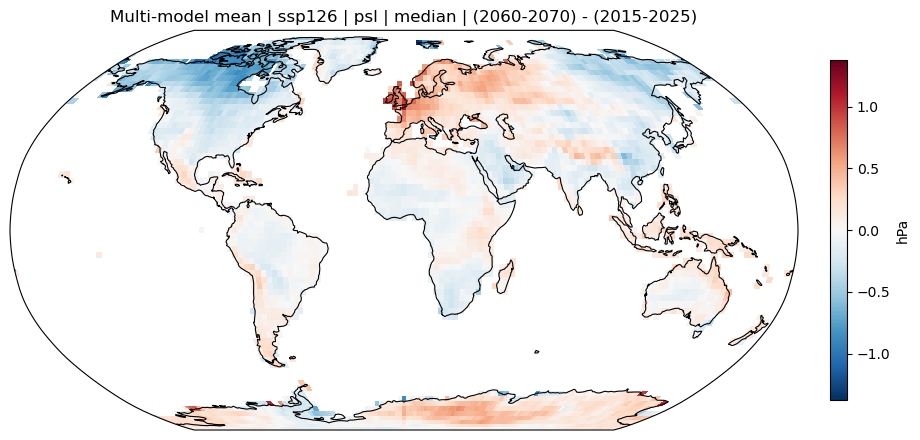

/Users/Caroline/miniconda3/envs/mamalakis/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/var/folders/v4/nmf8gnpn5vb2t2vlt0df52mh0000gn/T/ipykernel_2023/606453315.py:48: RuntimeWarning: Mean of empty slice
  out_map = np.nanmean(ens_maps, axis=0)


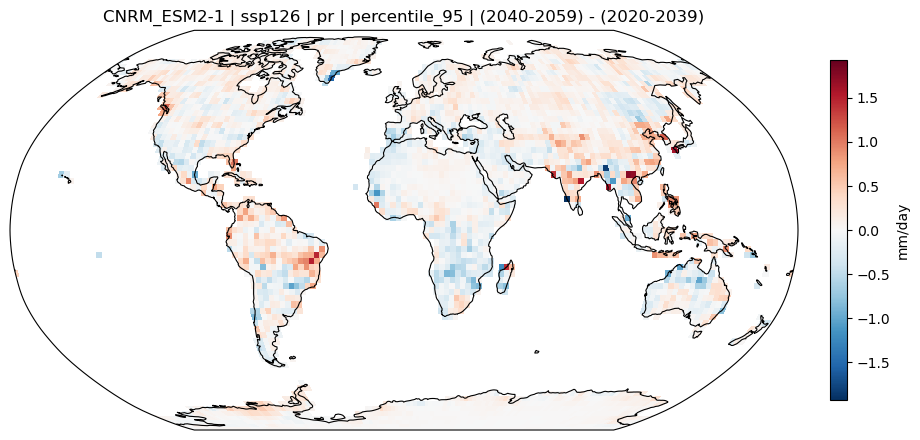

In [74]:
if __name__ == "__main__":
    # Example 1: Multi-model mean temperature change
    script1_global_map(
        varname="psl",
        scenario="ssp126",
        period1=(2015, 2025),
        period2=(2060, 2070),
        stat="median",
        multimodel=True,
        model_name=None
    )

    # Example 2: Single model precipitation change (95th percentile)
    script1_global_map(
         varname="pr",
         scenario="ssp126",
         period1=(2020, 2039),
         period2=(2040, 2059),
         stat="percentile_95",
         multimodel=False,
         model_name="CNRM_ESM2-1"
     )


## Script 2 Main Function: Time Series Plot

Produces a plot of a time series from 2015 to 2100 for the selected variable, scenario, and model. Will show all 5 trajectories within a model. 

Inputs: 
- File
- Variable
- Scenario
- Base period (2015-2100 default)
- Region (entire globe default, lon/lat range)
- Statistic
- Number models returned (all 5 default, single model name) 


In [75]:
def script2_time_series(
    file: str,
    varname: str,
    scenario: str,
    period: tuple[int, int] = (2015, 2100),
    region: tuple[int,int, int, int] | None = None,
    stat: str = "mean",
    multimodel: bool = True,
    model_name: str | None = None,

):
    """
    Produces a time series plot where the inputs are:
      file: the file to be analyzed
      varname: one of tas, tasmax, tasmin, pr, psl, sfcWind, mrsos
      scenario: "ssp119" or "ssp126"
      base_pd: None (default), (start_year, end_year)
      region: entire globe (default), lon/lat range
      stat: mean (default), std, median, percentile_XX
      multimodel: True (average across all 5 models) (default)
      model_name: if not None, ignore multimodel and plot only that model
    """

    # Variable check
    if varname not in VAR_TO_INDEX:
        raise ValueError(f"varname must be one of {list(VAR_TO_INDEX.keys())}")

    # Model check
    selected_files = FILES
    if model_name is not None:
        selected_files = [fp for fp in FILES if get_model_name(fp) == model_name]
        if len(selected_files) == 0:
            raise ValueError(
                f"Model '{model_name}' not found. Available: {[get_model_name(f) for f in FILES]}"
            )
        
    # Opening dataset 
    ds = xr.open_dataset(file)
 
    # Variable manipulation (Splitting tuples)
    ya, yb = period
    t_start, t_end = ya - 2015, yb - 2015
    if region is not None:
        lat1, lat2, lon1, lon2 = region
    # How to do global?
       
    # Open dataset and perform data subsetting using xarray
    ds = xr.open_dataset(file)
    data_subset = ds.sel(
        lat=slice(lat1, lat2), 
        lon=slice(lon1, lon2),
        time=slice(t_start, t_end)
    )
    lats_subset = ds.sel(lat=slice(lat1, lat2))
    ds.close()
    
    # Cosine logic
    #cosl = np.cos(np.pi * lats_subset / 180)
    #n_models, n_years, n_lats, n_lons = data_subset.shape
    #coslat = np.tile(cosl, (n_models, n_years, n_lons, 1)) 
    #coslat = np.swapaxes(coslat, -1, -2)
"""
    # Plot
    # for i in np.arange(0,10,1):
    #     plt.plot(np.arange(ya, yb), scenario[i,:],'C6',alpha=0.3)
    plt.plot(np.arange(ya, yb), np.chosen_stat(scenario,axis=0),'C6',label=f'{varname} {stat} {scenario}', linewidth=3)

    # # Plot settings
    plt.xlabel('Year')
    plt.ylabel('{varname} {stat}')
    plt.axis('tight')
    plt.grid(color='0.8')


    plt.legend()
    plt.show()
    """

"\n    # Plot\n    # for i in np.arange(0,10,1):\n    #     plt.plot(np.arange(ya, yb), scenario[i,:],'C6',alpha=0.3)\n    plt.plot(np.arange(ya, yb), np.chosen_stat(scenario,axis=0),'C6',label=f'{varname} {stat} {scenario}', linewidth=3)\n\n    # # Plot settings\n    plt.xlabel('Year')\n    plt.ylabel('{varname} {stat}')\n    plt.axis('tight')\n    plt.grid(color='0.8')\n\n\n    plt.legend()\n    plt.show()\n    "

In [76]:
def script2_time_series(
    file: str,
    varname: str,
    scenario: str,
    period: tuple[int, int] = (2015, 2100),
    region: tuple[int,int, int, int] | None = None,
    stat: str = "mean",
    multimodel: bool = True,
    model_name: str | None = None,

):
    """
    Produces a time series plot where the inputs are:
      file: the file to be analyzed
      varname: one of tas, tasmax, tasmin, pr, psl, sfcWind, mrsos
      scenario: "ssp119" or "ssp126"
      base_pd: None (default), (start_year, end_year)
      region: entire globe (default), lon/lat range
      stat: mean (default), std, median, percentile_XX
      multimodel: True (average across all 5 models) (default)
      model_name: if not None, ignore multimodel and plot only that model
    """

    # Variable check
    if varname not in VAR_TO_INDEX:
        raise ValueError(f"varname must be one of {list(VAR_TO_INDEX.keys())}")

    # Model check
    selected_files = FILES
    if model_name is not None:
        selected_files = [fp for fp in FILES if get_model_name(fp) == model_name]
        if len(selected_files) == 0:
            raise ValueError(
                f"Model '{model_name}' not found. Available: {[get_model_name(f) for f in FILES]}"
            )
        
    # Opening dataset 
    ds = xr.open_dataset(file)
 
    # Variable manipulation (Splitting tuples)
    ya, yb = period
    t_start, t_end = ya - 2015, yb - 2015
    if region is not None:
        lat1, lat2, lon1, lon2 = region
    # How to do global?
       
    # Open dataset and perform data subsetting using xarray
    ds = xr.open_dataset(file)
    data_subset = ds.sel(
        lat=slice(lat1, lat2), 
        lon=slice(lon1, lon2),
        time=slice(t_start, t_end)
    )
    lats_subset = ds.sel(lat=slice(lat1, lat2))
    ds.close()
    
    # Cosine logic
    #cosl = np.cos(np.pi * lats_subset / 180)
    #n_models, n_years, n_lats, n_lons = data_subset.shape
    #coslat = np.tile(cosl, (n_models, n_years, n_lons, 1)) 
    #coslat = np.swapaxes(coslat, -1, -2)
"""
    # Plot
    # for i in np.arange(0,10,1):
    #     plt.plot(np.arange(ya, yb), scenario[i,:],'C6',alpha=0.3)
    plt.plot(np.arange(ya, yb), np.chosen_stat(scenario,axis=0),'C6',label=f'{varname} {stat} {scenario}', linewidth=3)

    # # Plot settings
    plt.xlabel('Year')
    plt.ylabel('{varname} {stat}')
    plt.axis('tight')
    plt.grid(color='0.8')


    plt.legend()
    plt.show()
    """

"\n    # Plot\n    # for i in np.arange(0,10,1):\n    #     plt.plot(np.arange(ya, yb), scenario[i,:],'C6',alpha=0.3)\n    plt.plot(np.arange(ya, yb), np.chosen_stat(scenario,axis=0),'C6',label=f'{varname} {stat} {scenario}', linewidth=3)\n\n    # # Plot settings\n    plt.xlabel('Year')\n    plt.ylabel('{varname} {stat}')\n    plt.axis('tight')\n    plt.grid(color='0.8')\n\n\n    plt.legend()\n    plt.show()\n    "

In [77]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os

def script2_time_series(
    files: str | list[str], # Renamed back to files; accepts single path or list
    varname: str,
    scenario: str,
    period: tuple[int, int] | None = (2015, 2100),
    region: tuple[float, float, float, float] | None = None,
    stat: str = "mean",
    multimodel: bool = True,
    model_name: str | None = None,
):
    """
    Produces a time series plot where the inputs are:
      files: the file (or list of files) to be analyzed
      varname: one of tas, tasmax, tasmin, pr, psl, sfcWind, mrsos
      scenario: "ssp119" or "ssp126"
      period: (start_year, end_year)
      region: entire globe (default), (lat_min, lat_max, lon_min, lon_max)
      stat: mean (default), std, median, percentile_XX
      multimodel: True (average across all models)
      model_name: if not None, ignore multimodel and plot only that model
    """

    # Convert single file string to a list for consistent looping
    if isinstance(files, str):
        file_list = [files]
    else:
        file_list = files

    # Model filtering logic
    if model_name is not None:
        selected_files = [f for f in file_list if model_name in os.path.basename(f)]
    else:
        selected_files = file_list

    all_model_data = []

    for f in selected_files:
        # Open dataset
        ds = xr.open_dataset(f)
        
        # Manipulate variables and subset time
        if period is not None:
            ya, yb = period
            ds = ds.sel(time=slice(f"{ya}", f"{yb}"))
        else:
            ya, yb = int(ds.time.dt.year[0]), int(ds.time.dt.year[-1])

        # Subset regions
        if region is not None:
            lat1, lat2, lon1, lon2 = region
            ds = ds.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))

        # Use cosine weighting (grid cell area decreases towards the poles)
        weights = np.cos(np.deg2rad(ds.lat))
        
        # Spatial averaging: apply weights to the variable and collapse the spatial dimensions
        if stat == "mean":
            ts = ds[varname].weighted(weights).mean(dim=("lat", "lon"))
        else:
            # Standard mean for other stats
            ts = ds[varname].mean(dim=("lat", "lon"))
        
        # Load data and close dataset
        all_model_data.append(ts.compute())
        ds.close()

    # Combine models and calculate ensemble stats
    combined = xr.concat(all_model_data, dim="model")
    ensemble_mean = combined.mean(dim="model")
    ensemble_std = combined.std(dim="model")

    # Plotting
    plt.figure(figsize=(10, 5))
    
    if multimodel and len(selected_files) > 1:
        # Plot model spread if multimodel is True and multiple models exist
        plt.fill_between(ensemble_mean.time, 
                         ensemble_mean - ensemble_std, 
                         ensemble_mean + ensemble_std, 
                         color='C6', alpha=0.2, label='Model Spread (±1 std)')
        plt.plot(ensemble_mean.time, ensemble_mean, 'C6', label=f'Ensemble Mean {scenario}', linewidth=3)
    else:
        # Plot single model
        label_name = model_name if model_name else "Model"
        plt.plot(ensemble_mean.time, ensemble_mean, 'C6', label=f'{varname} {label_name}', linewidth=2)

    # Plot settings
    plt.xlabel('Year')
    plt.ylabel(f'{varname} ({stat})')
    plt.title(f'Time Series: {varname} - {scenario}')
    plt.axis('tight')
    plt.grid(color='0.8', linestyle='--')
    plt.legend()
    
    plt.show()

In [103]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os

VAR_TO_INDEX = {
    "tas": 0, "tasmax": 1, "tasmin": 2, "pr": 3, 
    "psl": 4, "sfcWind": 5, "mrsos": 6
}

def script2_time_series(
    files: str | list[str],
    varname: str,
    scenario: str,
    period: tuple[int, int] | None = (2015, 2100),
    region: tuple[int, int, int, int] | None = None,
    stat: str = "mean",
    multimodel: bool = True,
    model_name: str | None = None,
):
    """
    Produces a time series plot where the inputs are:
      file: the file to be analyzed
      varname: one of tas, tasmax, tasmin, pr, psl, sfcWind, mrsos
      scenario: "ssp119" or "ssp126"
      base_pd: None (default), (start_year, end_year)
      region: entire globe (default), lon/lat range
      stat: mean (default), std, median, percentile_XX
      multimodel: True (average across all 5 models) (default)
      model_name: if not None, ignore multimodel and plot only that model
    """

    # Variable check
    if varname not in VAR_TO_INDEX:
        raise ValueError(f"varname must be one of {list(VAR_TO_INDEX.keys())}")

    # Model check
    if isinstance(files, str):
        file_list = [files]
    else:
        file_list = files

    if model_name is not None:
        file_list = [f for f in file_list if model_name in os.path.basename(f)]

    all_ts = []
    target_var = f"data_{scenario}"

    for f in file_list:
        # Opening dataset 
        ds = xr.open_dataset(f)
        
        # Variable manipulation (Selecting from VAR_TO_INDEX)
        data_array = ds[target_var].isel(variable=VAR_TO_INDEX[varname])

        # Subset time
        if period is not None:
            ya, yb = period
            data_array = data_array.sel(time=slice(str(ya), str(yb)))
        else:
            ya, yb = int(data_array.time[0]), int(data_array.time[-1])
            
        # Subset regions
        if region is not None:
            lat1, lat2, lon1, lon2 = region
            data_array = data_array.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
           
        # Cosine logic
        cosl = np.cos(np.pi * data_array.lat / 180)
        
        # Spatial averaging
        ts = data_array.weighted(cosl).mean(dim=("lat", "lon"))
        all_ts.append(ts.compute())
        ds.close()

    # Combine data and handle multimodel averaging
    # Converts the list of 5 time-series into a 2D array of shape (5, time)
    combined_data = np.array([da.values for da in all_ts])
    
    # Collapse models (axis 0) into a single mean and standard deviation
    # This reduces shape from (5, 1) to (1,)
    y_mean = np.mean(combined_data, axis=0).flatten()
    y_std = np.std(combined_data, axis=0).flatten()
    years = np.atleast_1d(all_ts[0].time.values)

    # Plot
    plt.figure(figsize=(10, 6))
    
    if multimodel and len(file_list) > 1:
        plt.fill_between(years, y_mean - y_std, y_mean + y_std, color='C6', alpha=0.2, label='Model Spread')
        plt.plot(years, y_mean, 'C6o-', label=f'{varname} {stat} {scenario}', linewidth=3)
    else:
        plt.plot(years, y_mean, 'C6o-', label=f'{varname} {stat} {scenario}', linewidth=3)

    # # Plot settings
    plt.xlabel('Year')
    plt.ylabel(f'{varname} {stat}')
    plt.axis('tight')
    plt.grid(color='0.8')

    plt.legend()
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

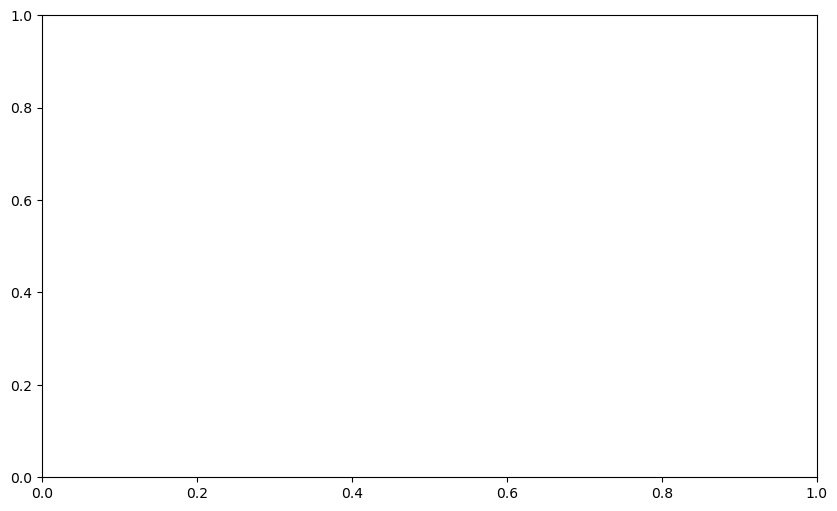

In [104]:
if __name__ == "__main__":

   # Example 1: Multimodel time-series of tas in ssp119 scenario
    script2_time_series(
        files = "CNRM_ESM2-1_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
        varname="tas",
        scenario="ssp119", 
        period=(2020, 2039), 
        region=(-80, 80, 100, 200)
        # stat is mean as default
        # Multimodel is True by default
        # Model_name is None by default
    )